In [1]:
%load_ext autoreload
%autoreload 2
%env CUDA_VISIBLE_DEVICES=2
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import matplotlib

from sklearn.decomposition import PCA

import seaborn as sns
import ncvis
import os
import numpy as np
import sys
sys.path.append("..")
from vis_utils.loaders import load_pendigits
from vis_utils.plot import add_scale
from vis_utils.utils import  save_dict, load_dict, kNN_graph, find_ab_params, compute_low_dim_sims


import scipy.sparse

env: CUDA_VISIBLE_DEVICES=2


In [295]:
root_path = "/export/ial-nfs/user/sdamrich/nce_data"
fig_path = "/export/ial-nfs/user/sdamrich/nce_data/figures"
# get data
x, y  = load_pendigits(root_path)

# NCVis


In [296]:
# parameters for all methods
a = 1.0
b = 1.0
seed = 0
n_noise = 5
alpha_Q = 0.001
alpha = 1.0

k = 15
cmap = matplotlib.cm.get_cmap("tab10")

In [297]:
file_name = os.path.join(root_path,
                         "pendigits",
                         f"sknn_graph_k_{k}_metric_euclidean.npz")
try:
    sknn_graph = scipy.sparse.load_npz(file_name)
except IOError:
    knn_graph = kNN_graph(x.astype("float"),
                          k,
                          metric="euclidean").cpu().numpy().flatten()
    knn_graph = scipy.sparse.coo_matrix((np.ones(len(x)*k),
                                         (np.repeat(np.arange(x.shape[0]), k),
                                          knn_graph)),
                                        shape=(len(x), len(x)))
    sknn_graph = knn_graph.maximum(knn_graph.transpose()).tocoo()

    scipy.sparse.save_npz(file_name, sknn_graph)


affinities = np.stack([sknn_graph.row, sknn_graph.col], axis=1)

In [298]:
# load / compute and save 2D PCA for initialisation
try:
    pca2 = np.load(os.path.join(root_path, "PCA2D.np"))
except FileNotFoundError:
    pca_projector = PCA(n_components = 2)
    pca2 = pca_projector.fit_transform(np.array(x))
    np.save(os.path.join(root_path, "PCA2D.npy"), pca2)

## normal NCVis

In [75]:
rescale = False
n_epochs = 50
fix_Q = False
noise_in_ratio = 0
learn_Q = True
file_name = os.path.join(root_path,
                         "pendigits",
                         f"ncvis_bin_k_{k}_n_epochs_{n_epochs}_fix_Q_{fix_Q}_noise_in_ratio_{noise_in_ratio}_learn_Q_{learn_Q}_seed_{seed}_n_noise_{n_noise}_alpha_{alpha}_alpha_Q_{alpha_Q}_a_{a}_b_{b}_init_pca_rescale_{rescale}.pkl")
if rescale:
    pca_ncvis = pca2 / (np.std(pca2[:, 0]) * 10000)
else:
    pca_ncvis = pca2

try:
    ncvis_data = load_dict(file_name)
except FileNotFoundError:
    ncvisualizer = ncvis.NCVis(distance='correlation',
                               n_epochs=n_epochs,
                               random_seed=seed,
                               fix_Q=fix_Q,
                               noise_in_ratio=noise_in_ratio,
                               learn_Q=learn_Q,
                               n_noise=n_noise,
                               alpha=alpha,
                               alpha_Q=alpha_Q,
                               a=a,
                               b=b)

    embd = ncvisualizer.fit_transform(x, affinities=affinities, init=pca_ncvis)
    save_dict(ncvisualizer.aux_data, file_name)
    ncvis_data = ncvisualizer.aux_data


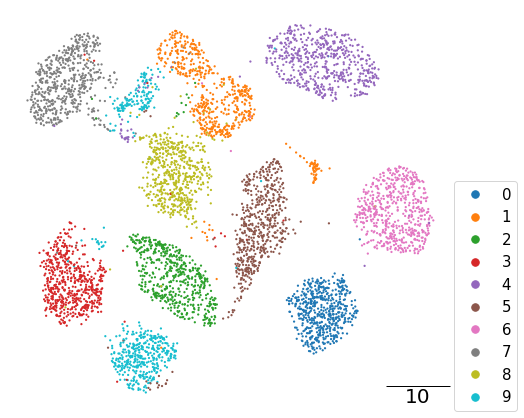

In [76]:
epoch = -1

plt.figure(figsize=(8, 8))

plt.scatter(*ncvis_data["embds"][epoch].T, c=y, s=20, marker=".", cmap="tab10",
            edgecolor="none", alpha=1.0)

plt.axis("off")
plt.gca().set_aspect("equal")


scalebar = AnchoredSizeBar(plt.gca().transData,
                           10,
                           '10',
                           loc="lower right",
                           frameon=False)

plt.gca().add_artist(scalebar)

# dummy dots for legend
dots = []
for i in range(len(np.unique(y))):
    dot = mlines.Line2D([], [], color=cmap(i), marker='.', linestyle="none",
                        markersize=15, label=np.unique(y)[i])
    dots.append(dot)

plt.legend(handles=dots, prop={'size': 15}, loc=(1, 0))

#plt.savefig(os.path.join(fig_path,
#                         f"ncvis_pen_digits_n_epochs_{n_epochs}_fix_Q_{fix_Q}_fix_noise_{fix_noise}_seed_{seed}_n_noise_{n_noise}_alpha_{alpha}_alpha_Q_{alpha_Q}.png"),
#            bbox_inches='tight',
#            pad_inches=0,
#            dpi=300)

231764.88
357074.20299349463


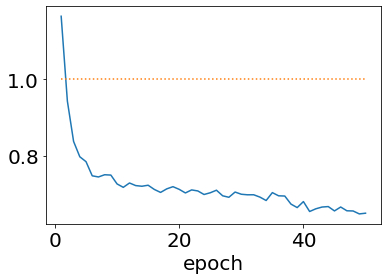

In [78]:

# relative normaliztion
start = 1
rel_norm = ncvis_data["normalization"][start:] / np.exp(ncvis_data["qs"])[start:]
epochs = np.arange(len(ncvis_data["normalization"]))[start:]

plt.plot(epochs, rel_norm)
#box_pts=11
#box = np.ones(box_pts)/box_pts
#rel_norm_smooth = np.convolve(rel_norm, box, mode='valid')
#plt.plot(np.arange(box_pts, box_pts+len(rel_norm_smooth)), rel_norm_smooth)

plt.plot(epochs, np.ones(len(epochs)), linestyle="dotted")

plt.xlabel("epoch")
#plt.ylabel(r" $\sum_{ij} \frac{q^0(ij)}{Z}$", rotation=0, labelpad = 50)


#plt.savefig(os.path.join(fig_path,
#                         f"ncvis_pen_digits_rel_norm_n_epochs_{n_epochs}_fix_Q_{fix_Q}_fix_noise_{fix_noise}_seed_{seed}_n_noise_{n_noise}_alpha_{alpha}_alpha_Q_{alpha_Q}_seed_{seed}_start_{start}.png"),
#            bbox_inches = 'tight',
#            pad_inches = 0,
#            dpi=300)
print(ncvis_data["normalization"][-1])
print(np.exp(ncvis_data["qs"][-1]))

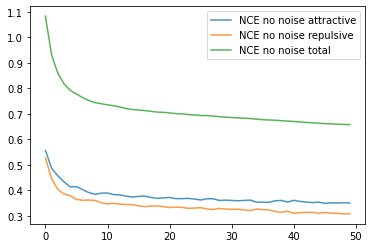

In [24]:
# the losses with true and learnt normalisation constant are very close
start = 1
with sns.color_palette("tab10", n_colors=3):
    plt.plot(ncvis_data["nce_loss"][start:, 0],
             alpha=0.8,
             label="NCE no noise attractive")
    #plt.plot(ncvis_data["nce_loss_norm"][start:, 0],
    #         alpha=0.8,
    #         label="NCE norm attractive")

    plt.plot(ncvis_data["nce_loss"][start:, 1],
             alpha=0.8,
             label="NCE no noise repulsive")
    #plt.plot(ncvis_data["nce_loss_norm"][start:, 1],
    #         alpha=0.8,
    #         label="NCE norm repulsive")

    plt.plot(ncvis_data["nce_loss"][start:, 0] + ncvis_data["nce_loss"][start:, 1],
             alpha=0.8,
             label="NCE no noise total")
    #plt.plot(ncvis_data["nce_loss_norm"][start:, 0]+ncvis_data["nce_loss_norm"][start:, 1],
    #         alpha=0.8,
    #         label="NCE norm total")
plt.legend()
a, b = find_ab_params(1.0, 0.4)

In [25]:
low_pos_sims = compute_low_dim_sims(
    embedding1=ncvis_data["embds"][-1][sknn_graph.row],
    # embd_after[graph.row],
    embedding2=ncvis_data["embds"][-1][sknn_graph.col],
    # embd_after[graph.col],
    a=a,
    b=b,
    sim_func="cauchy",
    eps=1e-10)  # not much change in the histograms for 1e-4 - 1e-10


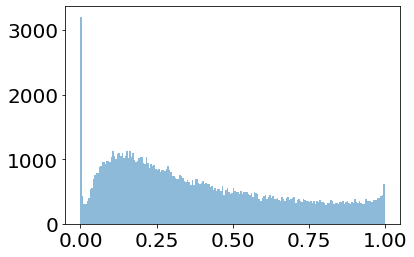

In [31]:

plt.figure()
plt.rcParams['font.size'] = 20

#_, _, _ = plt.hist(target_sim_inv_sq_pos.data, bins=200, range= (0, 200), alpha=0.5, label=r"$\frac{p(ij)}{mp_n(ij)}$")
_, _, _ = plt.hist(low_pos_sims, bins=200, range=(0, 1), alpha=0.5,
                   label=r"$\tilde{q}^0(ij)$")

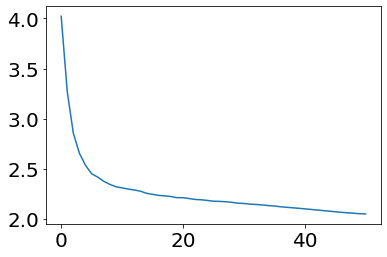

In [30]:

plt.plot(ncvis_data["kl_div"])

# NCVis without learnt Z

## noise_in_ratio=0 (normal noise)

In [79]:
rescale = False
n_epochs = 50
fix_Q = False
noise_in_ratio = 0
learn_Q = False
file_name = os.path.join(root_path,
                         "pendigits",
                         f"ncvis_bin_k_{k}_n_epochs_{n_epochs}_fix_Q_{fix_Q}_noise_in_ratio_{noise_in_ratio}_learn_Q_{learn_Q}_seed_{seed}_n_noise_{n_noise}_alpha_{alpha}_alpha_Q_{alpha_Q}_a_{a}_b_{b}_init_pca_rescale_{rescale}.pkl")
if rescale:
    pca_ncvis = pca2 / (np.std(pca2[:, 0]) * 10000)
else:
    pca_ncvis = pca2

try:
    ncvis_data = load_dict(file_name)
except FileNotFoundError:
    ncvisualizer = ncvis.NCVis(distance='correlation',
                               n_epochs=n_epochs,
                               random_seed=seed,
                               fix_Q=fix_Q,
                               noise_in_ratio=noise_in_ratio,
                               learn_Q=learn_Q,
                               n_noise=n_noise,
                               alpha=alpha,
                               alpha_Q=alpha_Q,
                               a=a,
                               b=b)

    embd = ncvisualizer.fit_transform(x, affinities=affinities, init=pca_ncvis)
    save_dict(ncvisualizer.aux_data, file_name)
    ncvis_data = ncvisualizer.aux_data


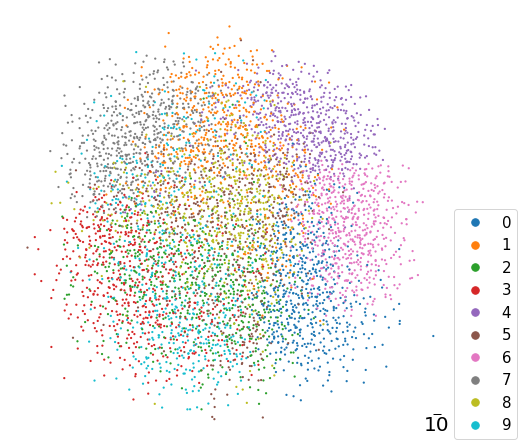

In [80]:
epoch = -1

plt.figure(figsize=(8, 8))

plt.scatter(*ncvis_data["embds"][epoch].T, c=y, s=20, marker=".", cmap="tab10",
            edgecolor="none", alpha=1.0)

plt.axis("off")
plt.gca().set_aspect("equal")


scalebar = AnchoredSizeBar(plt.gca().transData,
                           10,
                           '10',
                           loc="lower right",
                           frameon=False)

plt.gca().add_artist(scalebar)

# dummy dots for legend
dots = []
for i in range(len(np.unique(y))):
    dot = mlines.Line2D([], [], color=cmap(i), marker='.', linestyle="none",
                        markersize=15, label=np.unique(y)[i])
    dots.append(dot)

plt.legend(handles=dots, prop={'size': 15}, loc=(1, 0))

#plt.savefig(os.path.join(fig_path,
#                         f"ncvis_pen_digits_n_epochs_{n_epochs}_fix_Q_{fix_Q}_fix_noise_{fix_noise}_seed_{seed}_n_noise_{n_noise}_alpha_{alpha}_alpha_Q_{alpha_Q}.png"),
#            bbox_inches='tight',
#            pad_inches=0,
#            dpi=300)

In [103]:
len(x) * (len(x)-1) * 0.1 / 5

631575.6

3505.9265
1.0


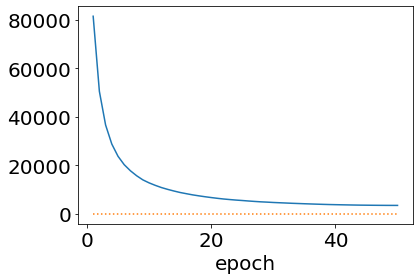

In [81]:
# relative normaliztion
start = 1
rel_norm = ncvis_data["normalization"][start:]
epochs = np.arange(len(ncvis_data["normalization"]))[start:]

plt.plot(epochs, rel_norm)
#box_pts=11
#box = np.ones(box_pts)/box_pts
#rel_norm_smooth = np.convolve(rel_norm, box, mode='valid')
#plt.plot(np.arange(box_pts, box_pts+len(rel_norm_smooth)), rel_norm_smooth)

plt.plot(epochs, np.ones(len(epochs)), linestyle="dotted")

plt.xlabel("epoch")
#plt.ylabel(r" $\sum_{ij} \frac{q^0(ij)}{Z}$", rotation=0, labelpad = 50)


#plt.savefig(os.path.join(fig_path,
#                         f"ncvis_pen_digits_rel_norm_n_epochs_{n_epochs}_fix_Q_{fix_Q}_fix_noise_{fix_noise}_seed_{seed}_n_noise_{n_noise}_alpha_{alpha}_alpha_Q_{alpha_Q}_seed_{seed}_start_{start}.png"),
#            bbox_inches = 'tight',
#            pad_inches = 0,
#            dpi=300)
print(ncvis_data["normalization"][-1])
print(np.exp(ncvis_data["qs"][-1]))

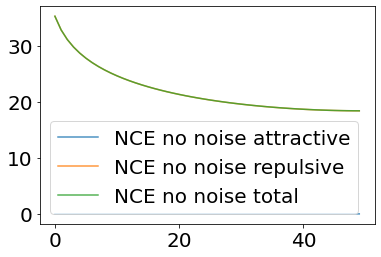

In [41]:
# the losses with true and learnt normalisation constant are very close
start = 1
with sns.color_palette("tab10", n_colors=3):
    plt.plot(ncvis_data["nce_loss"][start:, 0],
             alpha=0.8,
             label="NCE no noise attractive")
    #plt.plot(ncvis_data["nce_loss_norm"][start:, 0],
    #         alpha=0.8,
    #         label="NCE norm attractive")

    plt.plot(ncvis_data["nce_loss"][start:, 1],
             alpha=0.8,
             label="NCE no noise repulsive")
    #plt.plot(ncvis_data["nce_loss_norm"][start:, 1],
    #         alpha=0.8,
    #         label="NCE norm repulsive")

    plt.plot(ncvis_data["nce_loss"][start:, 0] + ncvis_data["nce_loss"][start:, 1],
             alpha=0.8,
             label="NCE no noise total")
    #plt.plot(ncvis_data["nce_loss_norm"][start:, 0]+ncvis_data["nce_loss_norm"][start:, 1],
    #         alpha=0.8,
    #         label="NCE norm total")
plt.legend()
a, b = find_ab_params(1.0, 0.4)

In [42]:
low_pos_sims = compute_low_dim_sims(
    embedding1=ncvis_data["embds"][-1][sknn_graph.row],
    # embd_after[graph.row],
    embedding2=ncvis_data["embds"][-1][sknn_graph.col],
    # embd_after[graph.col],
    a=a,
    b=b,
    sim_func="cauchy",
    eps=1e-10)  # not much change in the histograms for 1e-4 - 1e-10


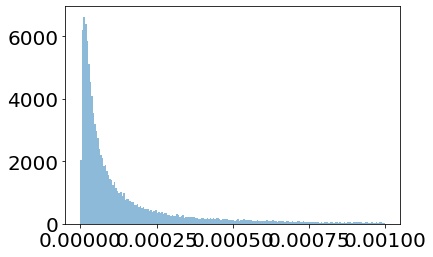

In [44]:

plt.figure()
plt.rcParams['font.size'] = 20

#_, _, _ = plt.hist(target_sim_inv_sq_pos.data, bins=200, range= (0, 200), alpha=0.5, label=r"$\frac{p(ij)}{mp_n(ij)}$")
_, _, _ = plt.hist(low_pos_sims, bins=200, range=(0, 0.001), alpha=0.5,
                   label=r"$\tilde{q}^0(ij)$")

## noise_in_ratio = 0.001

In [97]:
rescale = False
n_epochs = 50
fix_Q = False
noise_in_ratio = 0.001
learn_Q = False
file_name = os.path.join(root_path,
                         "pendigits",
                         f"ncvis_bin_k_{k}_n_epochs_{n_epochs}_fix_Q_{fix_Q}_noise_in_ratio_{noise_in_ratio}_learn_Q_{learn_Q}_seed_{seed}_n_noise_{n_noise}_alpha_{alpha}_alpha_Q_{alpha_Q}_a_{a}_b_{b}_init_pca_rescale_{rescale}.pkl")
if rescale:
    pca_ncvis = pca2 / (np.std(pca2[:, 0]) * 10000)
else:
    pca_ncvis = pca2

try:
    ncvis_data = load_dict(file_name)
except FileNotFoundError:
    ncvisualizer = ncvis.NCVis(distance='correlation',
                               n_epochs=n_epochs,
                               random_seed=seed,
                               fix_Q=fix_Q,
                               noise_in_ratio=noise_in_ratio,
                               learn_Q=learn_Q,
                               n_noise=n_noise,
                               alpha=alpha,
                               alpha_Q=alpha_Q,
                               a=a,
                               b=b)

    embd = ncvisualizer.fit_transform(x, affinities=affinities, init=pca_ncvis)
    save_dict(ncvisualizer.aux_data, file_name)
    ncvis_data = ncvisualizer.aux_data


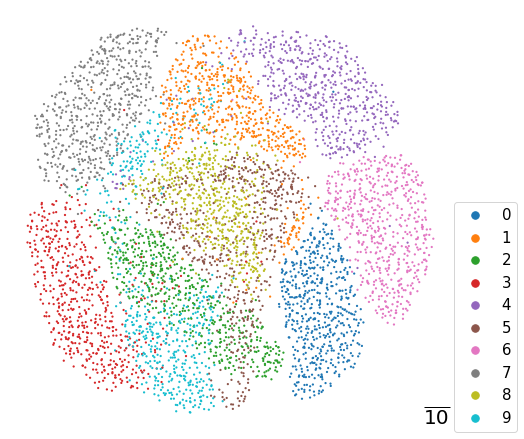

In [98]:
epoch = -1

plt.figure(figsize=(8, 8))

plt.scatter(*ncvis_data["embds"][epoch].T, c=y, s=20, marker=".", cmap="tab10",
            edgecolor="none", alpha=1.0)

plt.axis("off")
plt.gca().set_aspect("equal")


scalebar = AnchoredSizeBar(plt.gca().transData,
                           10,
                           '10',
                           loc="lower right",
                           frameon=False)

plt.gca().add_artist(scalebar)

# dummy dots for legend
dots = []
for i in range(len(np.unique(y))):
    dot = mlines.Line2D([], [], color=cmap(i), marker='.', linestyle="none",
                        markersize=15, label=np.unique(y)[i])
    dots.append(dot)

plt.legend(handles=dots, prop={'size': 15}, loc=(1, 0))

#plt.savefig(os.path.join(fig_path,
#                         f"ncvis_pen_digits_n_epochs_{n_epochs}_fix_Q_{fix_Q}_fix_noise_{fix_noise}_seed_{seed}_n_noise_{n_noise}_alpha_{alpha}_alpha_Q_{alpha_Q}.png"),
#            bbox_inches='tight',
#            pad_inches=0,
#            dpi=300)

25679.512
1.0


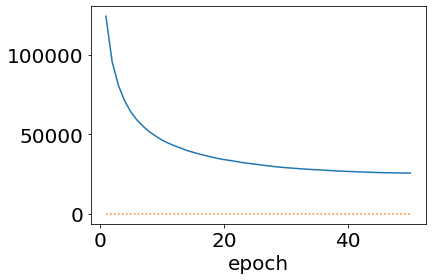

In [99]:
# relative normaliztion
start = 1
rel_norm = ncvis_data["normalization"][start:]
epochs = np.arange(len(ncvis_data["normalization"]))[start:]

plt.plot(epochs, rel_norm)
#box_pts=11
#box = np.ones(box_pts)/box_pts
#rel_norm_smooth = np.convolve(rel_norm, box, mode='valid')
#plt.plot(np.arange(box_pts, box_pts+len(rel_norm_smooth)), rel_norm_smooth)

plt.plot(epochs, np.ones(len(epochs)), linestyle="dotted")

plt.xlabel("epoch")
#plt.ylabel(r" $\sum_{ij} \frac{q^0(ij)}{Z}$", rotation=0, labelpad = 50)


#plt.savefig(os.path.join(fig_path,
#                         f"ncvis_pen_digits_rel_norm_n_epochs_{n_epochs}_fix_Q_{fix_Q}_fix_noise_{fix_noise}_seed_{seed}_n_noise_{n_noise}_alpha_{alpha}_alpha_Q_{alpha_Q}_seed_{seed}_start_{start}.png"),
#            bbox_inches = 'tight',
#            pad_inches = 0,
#            dpi=300)

print(ncvis_data["normalization"][-1])
print(np.exp(ncvis_data["qs"][-1]))

In [100]:
low_pos_sims = compute_low_dim_sims(
    embedding1=ncvis_data["embds"][-1][sknn_graph.row],
    # embd_after[graph.row],
    embedding2=ncvis_data["embds"][-1][sknn_graph.col],
    # embd_after[graph.col],
    a=a,
    b=b,
    sim_func="cauchy",
    eps=1e-10)  # not much change in the histograms for 1e-4 - 1e-10


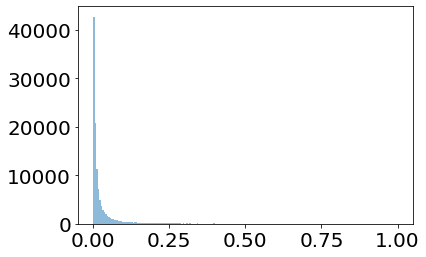

In [101]:

plt.figure()
plt.rcParams['font.size'] = 20

#_, _, _ = plt.hist(target_sim_inv_sq_pos.data, bins=200, range= (0, 200), alpha=0.5, label=r"$\frac{p(ij)}{mp_n(ij)}$")
_, _, _ = plt.hist(low_pos_sims, bins=200, range=(0, 1.0), alpha=0.5,
                   label=r"$\tilde{q}^0(ij)$")


## noise_in_ratio = 0.01

In [92]:
rescale = False
n_epochs = 50
fix_Q = False
noise_in_ratio = 0.01
learn_Q = False
file_name = os.path.join(root_path,
                         "pendigits",
                         f"ncvis_bin_k_{k}_n_epochs_{n_epochs}_fix_Q_{fix_Q}_noise_in_ratio_{noise_in_ratio}_learn_Q_{learn_Q}_seed_{seed}_n_noise_{n_noise}_alpha_{alpha}_alpha_Q_{alpha_Q}_a_{a}_b_{b}_init_pca_rescale_{rescale}.pkl")
if rescale:
    pca_ncvis = pca2 / (np.std(pca2[:, 0]) * 10000)
else:
    pca_ncvis = pca2

try:
    ncvis_data = load_dict(file_name)
except FileNotFoundError:
    ncvisualizer = ncvis.NCVis(distance='correlation',
                               n_epochs=n_epochs,
                               random_seed=seed,
                               fix_Q=fix_Q,
                               noise_in_ratio=noise_in_ratio,
                               learn_Q=learn_Q,
                               n_noise=n_noise,
                               alpha=alpha,
                               alpha_Q=alpha_Q,
                               a=a,
                               b=b)

    embd = ncvisualizer.fit_transform(x, affinities=affinities, init=pca_ncvis)
    save_dict(ncvisualizer.aux_data, file_name)
    ncvis_data = ncvisualizer.aux_data


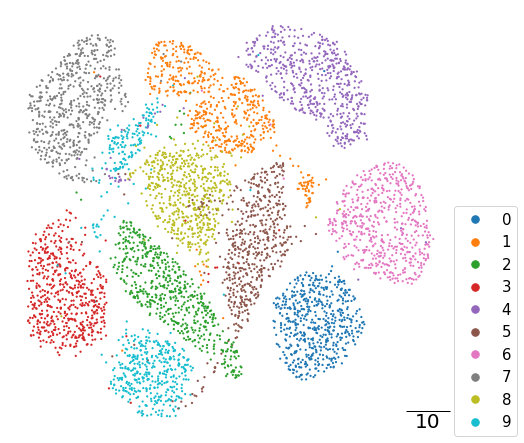

In [93]:
epoch = -1

plt.figure(figsize=(8, 8))

plt.scatter(*ncvis_data["embds"][epoch].T, c=y, s=20, marker=".", cmap="tab10",
            edgecolor="none", alpha=1.0)

plt.axis("off")
plt.gca().set_aspect("equal")


scalebar = AnchoredSizeBar(plt.gca().transData,
                           10,
                           '10',
                           loc="lower right",
                           frameon=False)

plt.gca().add_artist(scalebar)

# dummy dots for legend
dots = []
for i in range(len(np.unique(y))):
    dot = mlines.Line2D([], [], color=cmap(i), marker='.', linestyle="none",
                        markersize=15, label=np.unique(y)[i])
    dots.append(dot)

plt.legend(handles=dots, prop={'size': 15}, loc=(1, 0))

#plt.savefig(os.path.join(fig_path,
#                         f"ncvis_pen_digits_n_epochs_{n_epochs}_fix_Q_{fix_Q}_fix_noise_{fix_noise}_seed_{seed}_n_noise_{n_noise}_alpha_{alpha}_alpha_Q_{alpha_Q}.png"),
#            bbox_inches='tight',
#            pad_inches=0,
#            dpi=300)

81115.97
1.0


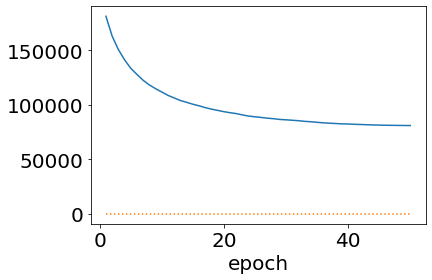

In [94]:
# relative normaliztion
start = 1
rel_norm = ncvis_data["normalization"][start:]
epochs = np.arange(len(ncvis_data["normalization"]))[start:]

plt.plot(epochs, rel_norm)
#box_pts=11
#box = np.ones(box_pts)/box_pts
#rel_norm_smooth = np.convolve(rel_norm, box, mode='valid')
#plt.plot(np.arange(box_pts, box_pts+len(rel_norm_smooth)), rel_norm_smooth)

plt.plot(epochs, np.ones(len(epochs)), linestyle="dotted")

plt.xlabel("epoch")
#plt.ylabel(r" $\sum_{ij} \frac{q^0(ij)}{Z}$", rotation=0, labelpad = 50)


#plt.savefig(os.path.join(fig_path,
#                         f"ncvis_pen_digits_rel_norm_n_epochs_{n_epochs}_fix_Q_{fix_Q}_fix_noise_{fix_noise}_seed_{seed}_n_noise_{n_noise}_alpha_{alpha}_alpha_Q_{alpha_Q}_seed_{seed}_start_{start}.png"),
#            bbox_inches = 'tight',
#            pad_inches = 0,
#            dpi=300)

print(ncvis_data["normalization"][-1])
print(np.exp(ncvis_data["qs"][-1]))

In [95]:
low_pos_sims = compute_low_dim_sims(
    embedding1=ncvis_data["embds"][-1][sknn_graph.row],
    # embd_after[graph.row],
    embedding2=ncvis_data["embds"][-1][sknn_graph.col],
    # embd_after[graph.col],
    a=a,
    b=b,
    sim_func="cauchy",
    eps=1e-10)  # not much change in the histograms for 1e-4 - 1e-10


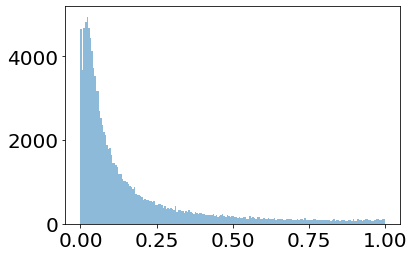

In [96]:

plt.figure()
plt.rcParams['font.size'] = 20

#_, _, _ = plt.hist(target_sim_inv_sq_pos.data, bins=200, range= (0, 200), alpha=0.5, label=r"$\frac{p(ij)}{mp_n(ij)}$")
_, _, _ = plt.hist(low_pos_sims, bins=200, range=(0, 1.0), alpha=0.5,
                   label=r"$\tilde{q}^0(ij)$")

## noise_in_ratio = 0.1

In [82]:
rescale = False
n_epochs = 50
fix_Q = False
noise_in_ratio = 0.1
learn_Q = False
file_name = os.path.join(root_path,
                         "pendigits",
                         f"ncvis_bin_k_{k}_n_epochs_{n_epochs}_fix_Q_{fix_Q}_noise_in_ratio_{noise_in_ratio}_learn_Q_{learn_Q}_seed_{seed}_n_noise_{n_noise}_alpha_{alpha}_alpha_Q_{alpha_Q}_a_{a}_b_{b}_init_pca_rescale_{rescale}.pkl")
if rescale:
    pca_ncvis = pca2 / (np.std(pca2[:, 0]) * 10000)
else:
    pca_ncvis = pca2

try:
    ncvis_data = load_dict(file_name)
except FileNotFoundError:
    ncvisualizer = ncvis.NCVis(distance='correlation',
                               n_epochs=n_epochs,
                               random_seed=seed,
                               fix_Q=fix_Q,
                               noise_in_ratio=noise_in_ratio,
                               learn_Q=learn_Q,
                               n_noise=n_noise,
                               alpha=alpha,
                               alpha_Q=alpha_Q,
                               a=a,
                               b=b)

    embd = ncvisualizer.fit_transform(x, affinities=affinities, init=pca_ncvis)
    save_dict(ncvisualizer.aux_data, file_name)
    ncvis_data = ncvisualizer.aux_data


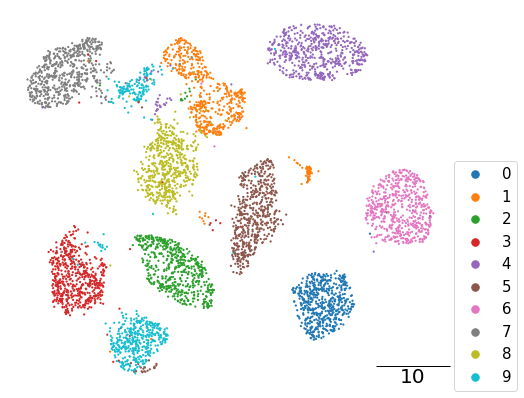

In [83]:
epoch = -1

plt.figure(figsize=(8, 8))

plt.scatter(*ncvis_data["embds"][epoch].T, c=y, s=20, marker=".", cmap="tab10",
            edgecolor="none", alpha=1.0)

plt.axis("off")
plt.gca().set_aspect("equal")


scalebar = AnchoredSizeBar(plt.gca().transData,
                           10,
                           '10',
                           loc="lower right",
                           frameon=False)

plt.gca().add_artist(scalebar)

# dummy dots for legend
dots = []
for i in range(len(np.unique(y))):
    dot = mlines.Line2D([], [], color=cmap(i), marker='.', linestyle="none",
                        markersize=15, label=np.unique(y)[i])
    dots.append(dot)

plt.legend(handles=dots, prop={'size': 15}, loc=(1, 0))

#plt.savefig(os.path.join(fig_path,
#                         f"ncvis_pen_digits_n_epochs_{n_epochs}_fix_Q_{fix_Q}_fix_noise_{fix_noise}_seed_{seed}_n_noise_{n_noise}_alpha_{alpha}_alpha_Q_{alpha_Q}.png"),
#            bbox_inches='tight',
#            pad_inches=0,
#            dpi=300)

345177.44
1.0


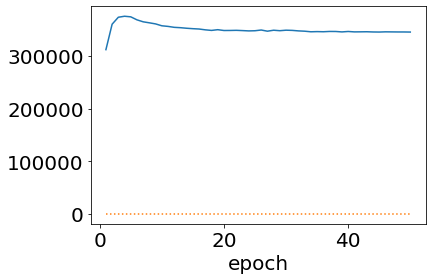

In [84]:
# relative normaliztion
start = 1
rel_norm = ncvis_data["normalization"][start:]
epochs = np.arange(len(ncvis_data["normalization"]))[start:]

plt.plot(epochs, rel_norm)
#box_pts=11
#box = np.ones(box_pts)/box_pts
#rel_norm_smooth = np.convolve(rel_norm, box, mode='valid')
#plt.plot(np.arange(box_pts, box_pts+len(rel_norm_smooth)), rel_norm_smooth)

plt.plot(epochs, np.ones(len(epochs)), linestyle="dotted")

plt.xlabel("epoch")
#plt.ylabel(r" $\sum_{ij} \frac{q^0(ij)}{Z}$", rotation=0, labelpad = 50)


#plt.savefig(os.path.join(fig_path,
#                         f"ncvis_pen_digits_rel_norm_n_epochs_{n_epochs}_fix_Q_{fix_Q}_fix_noise_{fix_noise}_seed_{seed}_n_noise_{n_noise}_alpha_{alpha}_alpha_Q_{alpha_Q}_seed_{seed}_start_{start}.png"),
#            bbox_inches = 'tight',
#            pad_inches = 0,
#            dpi=300)

print(ncvis_data["normalization"][-1])
print(np.exp(ncvis_data["qs"][-1]))

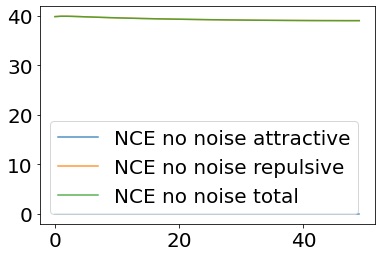

In [48]:
# the losses with true and learnt normalisation constant are very close
start = 1
with sns.color_palette("tab10", n_colors=3):
    plt.plot(ncvis_data["nce_loss"][start:, 0],
             alpha=0.8,
             label="NCE no noise attractive")
    #plt.plot(ncvis_data["nce_loss_norm"][start:, 0],
    #         alpha=0.8,
    #         label="NCE norm attractive")

    plt.plot(ncvis_data["nce_loss"][start:, 1],
             alpha=0.8,
             label="NCE no noise repulsive")
    #plt.plot(ncvis_data["nce_loss_norm"][start:, 1],
    #         alpha=0.8,
    #         label="NCE norm repulsive")

    plt.plot(ncvis_data["nce_loss"][start:, 0] + ncvis_data["nce_loss"][start:, 1],
             alpha=0.8,
             label="NCE no noise total")
    #plt.plot(ncvis_data["nce_loss_norm"][start:, 0]+ncvis_data["nce_loss_norm"][start:, 1],
    #         alpha=0.8,
    #         label="NCE norm total")
plt.legend()
a, b = find_ab_params(1.0, 0.4)

In [49]:
low_pos_sims = compute_low_dim_sims(
    embedding1=ncvis_data["embds"][-1][sknn_graph.row],
    # embd_after[graph.row],
    embedding2=ncvis_data["embds"][-1][sknn_graph.col],
    # embd_after[graph.col],
    a=a,
    b=b,
    sim_func="cauchy",
    eps=1e-10)  # not much change in the histograms for 1e-4 - 1e-10


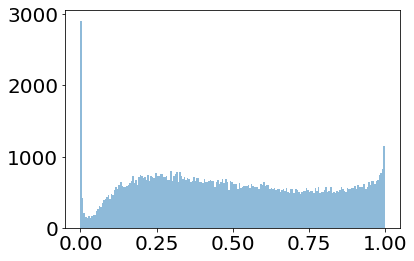

In [53]:

plt.figure()
plt.rcParams['font.size'] = 20

#_, _, _ = plt.hist(target_sim_inv_sq_pos.data, bins=200, range= (0, 200), alpha=0.5, label=r"$\frac{p(ij)}{mp_n(ij)}$")
_, _, _ = plt.hist(low_pos_sims, bins=200, range=(0, 1.0), alpha=0.5,
                   label=r"$\tilde{q}^0(ij)$")

## noise_in_ratio = 1

In [85]:
rescale = False
n_epochs = 50
fix_Q = False
noise_in_ratio = 1
learn_Q = False
file_name = os.path.join(root_path,
                         "pendigits",
                         f"ncvis_bin_k_{k}_n_epochs_{n_epochs}_fix_Q_{fix_Q}_noise_in_ratio_{noise_in_ratio}_learn_Q_{learn_Q}_seed_{seed}_n_noise_{n_noise}_alpha_{alpha}_alpha_Q_{alpha_Q}_a_{a}_b_{b}_init_pca_rescale_{rescale}.pkl")
if rescale:
    pca_ncvis = pca2 / (np.std(pca2[:, 0]) * 10000)
else:
    pca_ncvis = pca2

try:
    ncvis_data = load_dict(file_name)
except FileNotFoundError:
    ncvisualizer = ncvis.NCVis(distance='correlation',
                               n_epochs=n_epochs,
                               random_seed=seed,
                               fix_Q=fix_Q,
                               noise_in_ratio=noise_in_ratio,
                               learn_Q=learn_Q,
                               n_noise=n_noise,
                               alpha=alpha,
                               alpha_Q=alpha_Q,
                               a=a,
                               b=b)

    embd = ncvisualizer.fit_transform(x, affinities=affinities, init=pca_ncvis)
    save_dict(ncvisualizer.aux_data, file_name)
    ncvis_data = ncvisualizer.aux_data


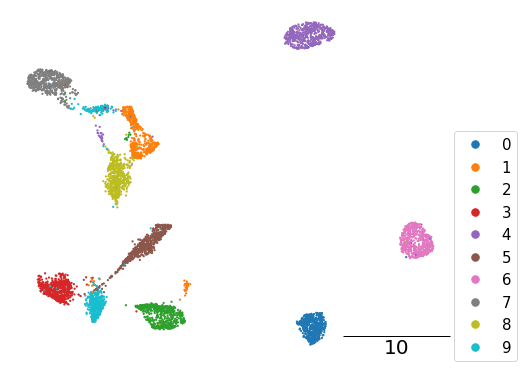

In [86]:
epoch = -1

plt.figure(figsize=(8, 8))

plt.scatter(*ncvis_data["embds"][epoch].T, c=y, s=20, marker=".", cmap="tab10",
            edgecolor="none", alpha=1.0)

plt.axis("off")
plt.gca().set_aspect("equal")


scalebar = AnchoredSizeBar(plt.gca().transData,
                           10,
                           '10',
                           loc="lower right",
                           frameon=False)

plt.gca().add_artist(scalebar)

# dummy dots for legend
dots = []
for i in range(len(np.unique(y))):
    dot = mlines.Line2D([], [], color=cmap(i), marker='.', linestyle="none",
                        markersize=15, label=np.unique(y)[i])
    dots.append(dot)

plt.legend(handles=dots, prop={'size': 15}, loc=(1, 0))

#plt.savefig(os.path.join(fig_path,
#                         f"ncvis_pen_digits_n_epochs_{n_epochs}_fix_Q_{fix_Q}_fix_noise_{fix_noise}_seed_{seed}_n_noise_{n_noise}_alpha_{alpha}_alpha_Q_{alpha_Q}.png"),
#            bbox_inches='tight',
#            pad_inches=0,
#            dpi=300)

1364876.8
1.0


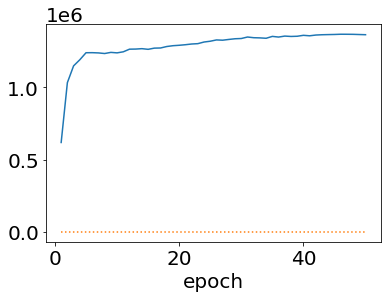

In [87]:
# relative normaliztion
start = 1
rel_norm = ncvis_data["normalization"][start:]
epochs = np.arange(len(ncvis_data["normalization"]))[start:]

plt.plot(epochs, rel_norm)
#box_pts=11
#box = np.ones(box_pts)/box_pts
#rel_norm_smooth = np.convolve(rel_norm, box, mode='valid')
#plt.plot(np.arange(box_pts, box_pts+len(rel_norm_smooth)), rel_norm_smooth)

plt.plot(epochs, np.ones(len(epochs)), linestyle="dotted")

plt.xlabel("epoch")
#plt.ylabel(r" $\sum_{ij} \frac{q^0(ij)}{Z}$", rotation=0, labelpad = 50)


#plt.savefig(os.path.join(fig_path,
#                         f"ncvis_pen_digits_rel_norm_n_epochs_{n_epochs}_fix_Q_{fix_Q}_fix_noise_{fix_noise}_seed_{seed}_n_noise_{n_noise}_alpha_{alpha}_alpha_Q_{alpha_Q}_seed_{seed}_start_{start}.png"),
#            bbox_inches = 'tight',
#            pad_inches = 0,
#            dpi=300)
print(ncvis_data["normalization"][-1])
print(np.exp(ncvis_data["qs"][-1]))

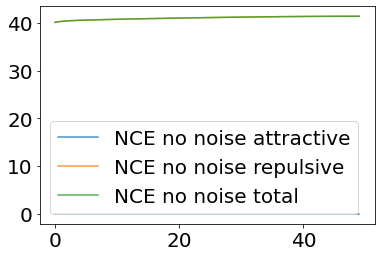

In [57]:
# the losses with true and learnt normalisation constant are very close
start = 1
with sns.color_palette("tab10", n_colors=3):
    plt.plot(ncvis_data["nce_loss"][start:, 0],
             alpha=0.8,
             label="NCE no noise attractive")
    #plt.plot(ncvis_data["nce_loss_norm"][start:, 0],
    #         alpha=0.8,
    #         label="NCE norm attractive")

    plt.plot(ncvis_data["nce_loss"][start:, 1],
             alpha=0.8,
             label="NCE no noise repulsive")
    #plt.plot(ncvis_data["nce_loss_norm"][start:, 1],
    #         alpha=0.8,
    #         label="NCE norm repulsive")

    plt.plot(ncvis_data["nce_loss"][start:, 0] + ncvis_data["nce_loss"][start:, 1],
             alpha=0.8,
             label="NCE no noise total")
    #plt.plot(ncvis_data["nce_loss_norm"][start:, 0]+ncvis_data["nce_loss_norm"][start:, 1],
    #         alpha=0.8,
    #         label="NCE norm total")
plt.legend()
a, b = find_ab_params(1.0, 0.4)

In [58]:
low_pos_sims = compute_low_dim_sims(
    embedding1=ncvis_data["embds"][-1][sknn_graph.row],
    # embd_after[graph.row],
    embedding2=ncvis_data["embds"][-1][sknn_graph.col],
    # embd_after[graph.col],
    a=a,
    b=b,
    sim_func="cauchy",
    eps=1e-10)  # not much change in the histograms for 1e-4 - 1e-10


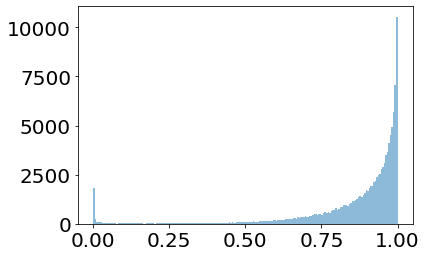

In [60]:

plt.figure()
plt.rcParams['font.size'] = 20

#_, _, _ = plt.hist(target_sim_inv_sq_pos.data, bins=200, range= (0, 200), alpha=0.5, label=r"$\frac{p(ij)}{mp_n(ij)}$")
_, _, _ = plt.hist(low_pos_sims, bins=200, range=(0, 1), alpha=0.5,
                   label=r"$\tilde{q}^0(ij)$")

## noise_in_ratio = 5

In [88]:
rescale = False
n_epochs = 50
fix_Q = False
noise_in_ratio = 5
learn_Q = False
file_name = os.path.join(root_path,
                         "pendigits",
                         f"ncvis_bin_k_{k}_n_epochs_{n_epochs}_fix_Q_{fix_Q}_noise_in_ratio_{noise_in_ratio}_learn_Q_{learn_Q}_seed_{seed}_n_noise_{n_noise}_alpha_{alpha}_alpha_Q_{alpha_Q}_a_{a}_b_{b}_init_pca_rescale_{rescale}.pkl")
if rescale:
    pca_ncvis = pca2 / (np.std(pca2[:, 0]) * 10000)
else:
    pca_ncvis = pca2

try:
    ncvis_data = load_dict(file_name)
except FileNotFoundError:
    ncvisualizer = ncvis.NCVis(distance='correlation',
                               n_epochs=n_epochs,
                               random_seed=seed,
                               fix_Q=fix_Q,
                               noise_in_ratio=noise_in_ratio,
                               learn_Q=learn_Q,
                               n_noise=n_noise,
                               alpha=alpha,
                               alpha_Q=alpha_Q,
                               a=a,
                               b=b)

    embd = ncvisualizer.fit_transform(x, affinities=affinities, init=pca_ncvis)
    save_dict(ncvisualizer.aux_data, file_name)
    ncvis_data = ncvisualizer.aux_data


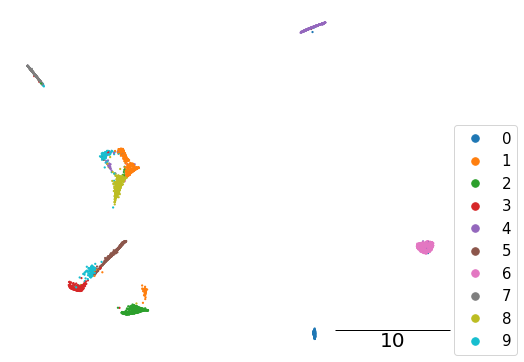

In [62]:
epoch = -1

plt.figure(figsize=(8, 8))

plt.scatter(*ncvis_data["embds"][epoch].T, c=y, s=20, marker=".", cmap="tab10",
            edgecolor="none", alpha=1.0)

plt.axis("off")
plt.gca().set_aspect("equal")


scalebar = AnchoredSizeBar(plt.gca().transData,
                           10,
                           '10',
                           loc="lower right",
                           frameon=False)

plt.gca().add_artist(scalebar)

# dummy dots for legend
dots = []
for i in range(len(np.unique(y))):
    dot = mlines.Line2D([], [], color=cmap(i), marker='.', linestyle="none",
                        markersize=15, label=np.unique(y)[i])
    dots.append(dot)

plt.legend(handles=dots, prop={'size': 15}, loc=(1, 0))

#plt.savefig(os.path.join(fig_path,
#                         f"ncvis_pen_digits_n_epochs_{n_epochs}_fix_Q_{fix_Q}_fix_noise_{fix_noise}_seed_{seed}_n_noise_{n_noise}_alpha_{alpha}_alpha_Q_{alpha_Q}.png"),
#            bbox_inches='tight',
#            pad_inches=0,
#            dpi=300)

2788407.0
1.0


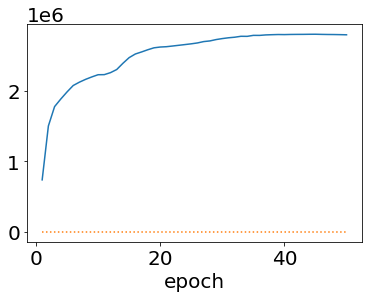

In [89]:
# relative normaliztion
start = 1
rel_norm = ncvis_data["normalization"][start:]
epochs = np.arange(len(ncvis_data["normalization"]))[start:]

plt.plot(epochs, rel_norm)
#box_pts=11
#box = np.ones(box_pts)/box_pts
#rel_norm_smooth = np.convolve(rel_norm, box, mode='valid')
#plt.plot(np.arange(box_pts, box_pts+len(rel_norm_smooth)), rel_norm_smooth)

plt.plot(epochs, np.ones(len(epochs)), linestyle="dotted")

plt.xlabel("epoch")
#plt.ylabel(r" $\sum_{ij} \frac{q^0(ij)}{Z}$", rotation=0, labelpad = 50)


#plt.savefig(os.path.join(fig_path,
#                         f"ncvis_pen_digits_rel_norm_n_epochs_{n_epochs}_fix_Q_{fix_Q}_fix_noise_{fix_noise}_seed_{seed}_n_noise_{n_noise}_alpha_{alpha}_alpha_Q_{alpha_Q}_seed_{seed}_start_{start}.png"),
#            bbox_inches = 'tight',
#            pad_inches = 0,
#            dpi=300)
print(ncvis_data["normalization"][-1])
print(np.exp(ncvis_data["qs"][-1]))

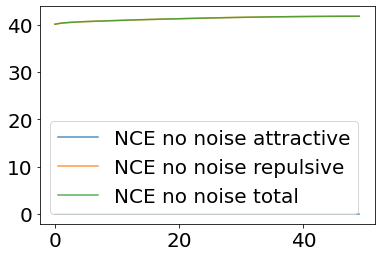

In [64]:
# the losses with true and learnt normalisation constant are very close
start = 1
with sns.color_palette("tab10", n_colors=3):
    plt.plot(ncvis_data["nce_loss"][start:, 0],
             alpha=0.8,
             label="NCE no noise attractive")
    #plt.plot(ncvis_data["nce_loss_norm"][start:, 0],
    #         alpha=0.8,
    #         label="NCE norm attractive")

    plt.plot(ncvis_data["nce_loss"][start:, 1],
             alpha=0.8,
             label="NCE no noise repulsive")
    #plt.plot(ncvis_data["nce_loss_norm"][start:, 1],
    #         alpha=0.8,
    #         label="NCE norm repulsive")

    plt.plot(ncvis_data["nce_loss"][start:, 0] + ncvis_data["nce_loss"][start:, 1],
             alpha=0.8,
             label="NCE no noise total")
    #plt.plot(ncvis_data["nce_loss_norm"][start:, 0]+ncvis_data["nce_loss_norm"][start:, 1],
    #         alpha=0.8,
    #         label="NCE norm total")
plt.legend()
a, b = find_ab_params(1.0, 0.4)

In [65]:
low_pos_sims = compute_low_dim_sims(
    embedding1=ncvis_data["embds"][-1][sknn_graph.row],
    # embd_after[graph.row],
    embedding2=ncvis_data["embds"][-1][sknn_graph.col],
    # embd_after[graph.col],
    a=a,
    b=b,
    sim_func="cauchy",
    eps=1e-10)  # not much change in the histograms for 1e-4 - 1e-10


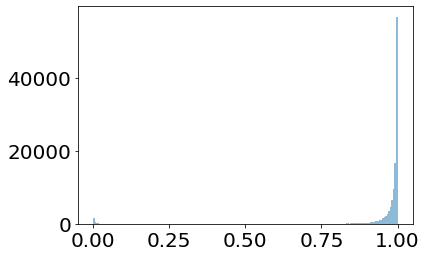

In [67]:

plt.figure()
plt.rcParams['font.size'] = 20

#_, _, _ = plt.hist(target_sim_inv_sq_pos.data, bins=200, range= (0, 200), alpha=0.5, label=r"$\frac{p(ij)}{mp_n(ij)}$")
_, _, _ = plt.hist(low_pos_sims, bins=200, range=(0, 1), alpha=0.5,
                   label=r"$\tilde{q}^0(ij)$")

## noise_in_ratio = 10

In [90]:
rescale = False
n_epochs = 50
fix_Q = False
noise_in_ratio = 10
learn_Q = False
file_name = os.path.join(root_path,
                         "pendigits",
                         f"ncvis_bin_k_{k}_n_epochs_{n_epochs}_fix_Q_{fix_Q}_noise_in_ratio_{noise_in_ratio}_learn_Q_{learn_Q}_seed_{seed}_n_noise_{n_noise}_alpha_{alpha}_alpha_Q_{alpha_Q}_a_{a}_b_{b}_init_pca_rescale_{rescale}.pkl")
if rescale:
    pca_ncvis = pca2 / (np.std(pca2[:, 0]) * 10000)
else:
    pca_ncvis = pca2

try:
    ncvis_data = load_dict(file_name)
except FileNotFoundError:
    ncvisualizer = ncvis.NCVis(distance='correlation',
                               n_epochs=n_epochs,
                               random_seed=seed,
                               fix_Q=fix_Q,
                               noise_in_ratio=noise_in_ratio,
                               learn_Q=learn_Q,
                               n_noise=n_noise,
                               alpha=alpha,
                               alpha_Q=alpha_Q,
                               a=a,
                               b=b)

    embd = ncvisualizer.fit_transform(x, affinities=affinities, init=pca_ncvis)
    save_dict(ncvisualizer.aux_data, file_name)
    ncvis_data = ncvisualizer.aux_data


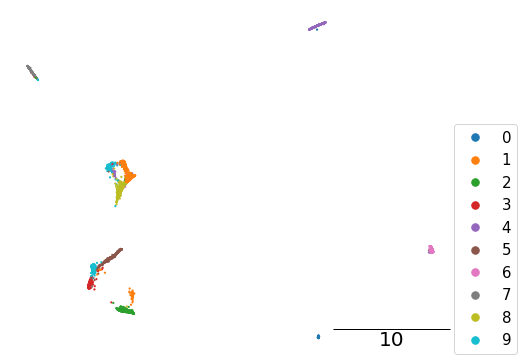

In [69]:
epoch = -1

plt.figure(figsize=(8, 8))

plt.scatter(*ncvis_data["embds"][epoch].T, c=y, s=20, marker=".", cmap="tab10",
            edgecolor="none", alpha=1.0)

plt.axis("off")
plt.gca().set_aspect("equal")


scalebar = AnchoredSizeBar(plt.gca().transData,
                           10,
                           '10',
                           loc="lower right",
                           frameon=False)

plt.gca().add_artist(scalebar)

# dummy dots for legend
dots = []
for i in range(len(np.unique(y))):
    dot = mlines.Line2D([], [], color=cmap(i), marker='.', linestyle="none",
                        markersize=15, label=np.unique(y)[i])
    dots.append(dot)

plt.legend(handles=dots, prop={'size': 15}, loc=(1, 0))

#plt.savefig(os.path.join(fig_path,
#                         f"ncvis_pen_digits_n_epochs_{n_epochs}_fix_Q_{fix_Q}_fix_noise_{fix_noise}_seed_{seed}_n_noise_{n_noise}_alpha_{alpha}_alpha_Q_{alpha_Q}.png"),
#            bbox_inches='tight',
#            pad_inches=0,
#            dpi=300)

3377674.8
1.0


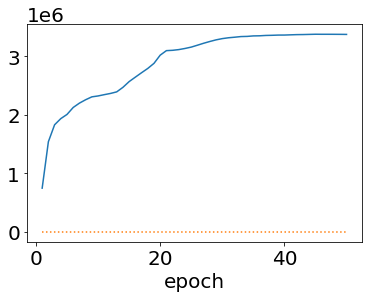

In [91]:
# relative normaliztion
start = 1
rel_norm = ncvis_data["normalization"][start:]
epochs = np.arange(len(ncvis_data["normalization"]))[start:]

plt.plot(epochs, rel_norm)
#box_pts=11
#box = np.ones(box_pts)/box_pts
#rel_norm_smooth = np.convolve(rel_norm, box, mode='valid')
#plt.plot(np.arange(box_pts, box_pts+len(rel_norm_smooth)), rel_norm_smooth)

plt.plot(epochs, np.ones(len(epochs)), linestyle="dotted")

plt.xlabel("epoch")
#plt.ylabel(r" $\sum_{ij} \frac{q^0(ij)}{Z}$", rotation=0, labelpad = 50)


#plt.savefig(os.path.join(fig_path,
#                         f"ncvis_pen_digits_rel_norm_n_epochs_{n_epochs}_fix_Q_{fix_Q}_fix_noise_{fix_noise}_seed_{seed}_n_noise_{n_noise}_alpha_{alpha}_alpha_Q_{alpha_Q}_seed_{seed}_start_{start}.png"),
#            bbox_inches = 'tight',
#            pad_inches = 0,
#            dpi=300)
print(ncvis_data["normalization"][-1])
print(np.exp(ncvis_data["qs"][-1]))

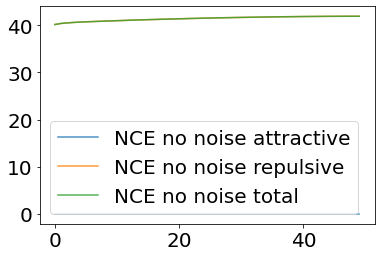

In [71]:
# the losses with true and learnt normalisation constant are very close
start = 1
with sns.color_palette("tab10", n_colors=3):
    plt.plot(ncvis_data["nce_loss"][start:, 0],
             alpha=0.8,
             label="NCE no noise attractive")
    #plt.plot(ncvis_data["nce_loss_norm"][start:, 0],
    #         alpha=0.8,
    #         label="NCE norm attractive")

    plt.plot(ncvis_data["nce_loss"][start:, 1],
             alpha=0.8,
             label="NCE no noise repulsive")
    #plt.plot(ncvis_data["nce_loss_norm"][start:, 1],
    #         alpha=0.8,
    #         label="NCE norm repulsive")

    plt.plot(ncvis_data["nce_loss"][start:, 0] + ncvis_data["nce_loss"][start:, 1],
             alpha=0.8,
             label="NCE no noise total")
    #plt.plot(ncvis_data["nce_loss_norm"][start:, 0]+ncvis_data["nce_loss_norm"][start:, 1],
    #         alpha=0.8,
    #         label="NCE norm total")
plt.legend()
a, b = find_ab_params(1.0, 0.4)

In [72]:
low_pos_sims = compute_low_dim_sims(
    embedding1=ncvis_data["embds"][-1][sknn_graph.row],
    # embd_after[graph.row],
    embedding2=ncvis_data["embds"][-1][sknn_graph.col],
    # embd_after[graph.col],
    a=a,
    b=b,
    sim_func="cauchy",
    eps=1e-10)  # not much change in the histograms for 1e-4 - 1e-10


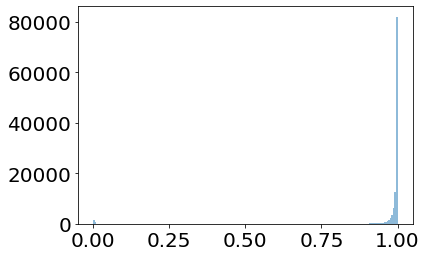

In [74]:

plt.figure()
plt.rcParams['font.size'] = 20

#_, _, _ = plt.hist(target_sim_inv_sq_pos.data, bins=200, range= (0, 200), alpha=0.5, label=r"$\frac{p(ij)}{mp_n(ij)}$")
_, _, _ = plt.hist(low_pos_sims, bins=200, range=(0, 1), alpha=0.5,
                   label=r"$\tilde{q}^0(ij)$")

## range of noise_in_ratio values

In [316]:
noise_in_ratios = np.array([5/len(x) / (len(x)-1),
                            #1e-6,
                            2e-6, 5e-6,
                            1e-5, 2e-5, 5e-5,
                            1e-4, 2e-4, 5e-4,
                            1e-3, 2e-3, 5e-3,
                            1e-2, 2e-2, 5e-2,
                            1e-1, 2e-1, 5e-1,
                            1, 2, 5,
                            10, 20, 50
                            ])

### learnt Z

In [277]:
ncvis_data_list = []
for noise_in_ratio in noise_in_ratios:
    rescale = False
    n_epochs = 750
    fix_Q = False
    learn_Q = True
    file_name = os.path.join(root_path,
                             "pendigits",
                             f"ncvis_bin_k_{k}_n_epochs_{n_epochs}_fix_Q_{fix_Q}_noise_in_ratio_{noise_in_ratio}_learn_Q_{learn_Q}_seed_{seed}_n_noise_{n_noise}_alpha_{alpha}_alpha_Q_{alpha_Q}_a_{a}_b_{b}_init_pca_rescale_{rescale}.pkl")
    if rescale:
        pca_ncvis = pca2 / (np.std(pca2[:, 0]) * 10000)
    else:
        pca_ncvis = pca2
    try:
        ncvis_data = load_dict(file_name)
    except FileNotFoundError:
        print(file_name)
        ncvisualizer = ncvis.NCVis(distance='correlation',
                                   n_epochs=n_epochs,
                                   random_seed=seed,
                                   fix_Q=fix_Q,
                                   noise_in_ratio=noise_in_ratio,
                                   learn_Q=learn_Q,
                                   n_noise=n_noise,
                                   alpha=alpha,
                                   alpha_Q=alpha_Q,
                                   a=a,
                                   b=b)

        embd = ncvisualizer.fit_transform(x, affinities=affinities, init=pca_ncvis)
        save_dict(ncvisualizer.aux_data, file_name)
        ncvis_data = ncvisualizer.aux_data
    ncvis_data_list.append(ncvis_data)
    print(f"Done with {noise_in_ratio}")

Done with 1.583341725044476e-07
Done with 1e-06
Done with 2e-06
Done with 5e-06
Done with 1e-05
Done with 2e-05
Done with 5e-05
Done with 0.0001
Done with 0.0002
Done with 0.0005
Done with 0.001
Done with 0.002
Done with 0.005
Done with 0.01
Done with 0.02
Done with 0.05
Done with 0.1
Done with 0.2
Done with 0.5
Done with 1.0
Done with 2.0
Done with 5.0
Done with 10.0
Done with 20.0
Done with 50.0


In [236]:
final_norms = np.array([data["normalization"][-1] for data in ncvis_data_list])
Zs = np.array([np.exp(data["qs"][-1]) for data in ncvis_data_list])

In [238]:
from sklearn.linear_model import LinearRegression
reg = LinearRegression().fit(noise_in_ratios[:, None], Zs[:, None]**-1)
print(reg.score(noise_in_ratios[:, None],Zs[:, None]**-1))
print(reg.coef_)
print(reg.intercept_)

0.9999939053746065
[[25.00049109]]
[-0.1606667]


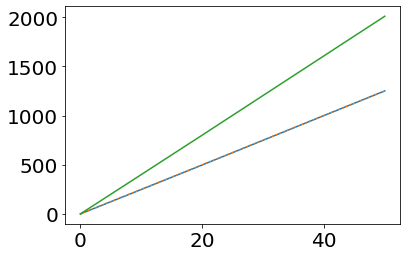

In [243]:
start = 0
#plt.plot(noise_in_ratios[start:end], final_norms[start:end])
plt.plot(noise_in_ratios[start:], Zs[start:]**-1)
plt.plot(noise_in_ratios[start:], noise_in_ratios[start:]*reg.coef_[0][0] + reg.intercept_[0], linestyle="dotted")
plt.plot(noise_in_ratios[start:], noise_in_ratios[start:] / (final_norms[start:] * 5 /(len(x)*(len(x)-1)))) # see onenote theory / nonnormalized nose
#plt.scatter(noise_in_ratios[start:end], Zs[start:end])
#plt.plot(noise_in_ratios[start:end], np.array(noise_in_ratios)[start:end]*len(x)*(len(x)-1) / 5.)
#plt.xscale("log")
#plt.yscale("log")

Text(0.5, 0, '$\\gamma$')

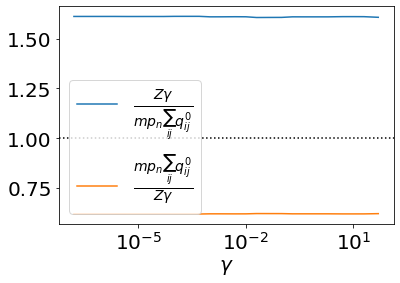

In [265]:
# difference in the slopes comes from the fact that NCVis prefers slightly non-normalized distributions
start =0
plt.plot(noise_in_ratios[start:],
         Zs[start:] / (noise_in_ratios[start:] / (final_norms[start:] * 5 /(len(x)*(len(x)-1))))**-1,
         label= r"$\frac{ Z \gamma}{m p_n\sum_{ij}q^0_{ij}}$")
plt.plot(noise_in_ratios[start:],
         (final_norms[start:] * 5 / (len(x)*(len(x)-1))) / (Zs[start:] *noise_in_ratios[start:] ),
         label=r"$\frac{m p_n\sum_{ij}q^0_{ij} }{Z \gamma}$")
plt.axhline(1, c="k", linestyle="dotted")
plt.xscale("log")
plt.legend()
plt.xlabel(r"$\gamma$")

### Z = 1

In [317]:
ncvis_data_list = []
for noise_in_ratio in noise_in_ratios:
    rescale = False
    n_epochs = 750
    fix_Q = False
    learn_Q = False
    file_name = os.path.join(root_path,
                             "pendigits",
                             f"ncvis_bin_k_{k}_n_epochs_{n_epochs}_fix_Q_{fix_Q}_noise_in_ratio_{noise_in_ratio}_learn_Q_{learn_Q}_seed_{seed}_n_noise_{n_noise}_alpha_{alpha}_alpha_Q_{alpha_Q}_a_{a}_b_{b}_init_pca_rescale_{rescale}.pkl")
    if rescale:
        pca_ncvis = pca2 / (np.std(pca2[:, 0]) * 10000)
    else:
        pca_ncvis = pca2
    try:
        ncvis_data = load_dict(file_name)
    except FileNotFoundError:
        ncvisualizer = ncvis.NCVis(distance='correlation',
                                   n_epochs=n_epochs,
                                   random_seed=seed,
                                   fix_Q=fix_Q,
                                   noise_in_ratio=noise_in_ratio,
                                   learn_Q=learn_Q,
                                   n_noise=n_noise,
                                   alpha=alpha,
                                   alpha_Q=alpha_Q,
                                   a=a,
                                   b=b)

        embd = ncvisualizer.fit_transform(x, affinities=affinities, init=pca_ncvis)
        save_dict(ncvisualizer.aux_data, file_name)
        ncvis_data = ncvisualizer.aux_data
    ncvis_data_list.append(ncvis_data)
    print(f"Done with {noise_in_ratio}")

Done with 1.583341725044476e-07
Done with 2e-06
Done with 5e-06
Done with 1e-05
Done with 2e-05
Done with 5e-05
Done with 0.0001
Done with 0.0002
Done with 0.0005
Done with 0.001
Done with 0.002
Done with 0.005
Done with 0.01
Done with 0.02
Done with 0.05
Done with 0.1
Done with 0.2
Done with 0.5
Done with 1.0
Done with 2.0
Done with 5.0
Done with 10.0
Done with 20.0
Done with 50.0


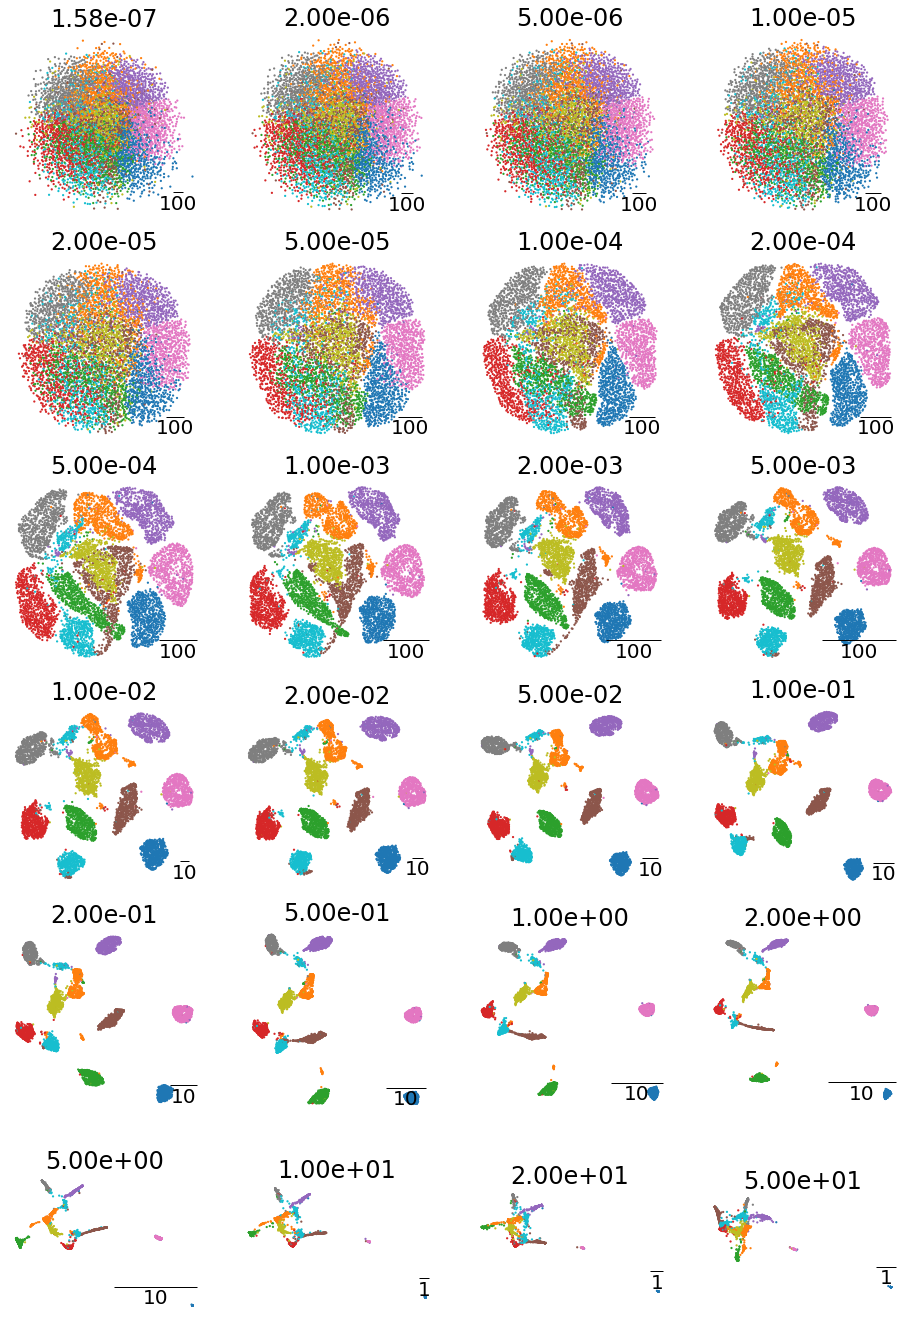

In [336]:
fig, ax = plt.subplots(6,4, figsize=(16,24))
n_exp = len(ncvis_data_list)
for i in range(n_exp):
    embd = ncvis_data_list[i]["embds"][-1]
    cax = ax[int(i / 4), i % 4]
    cax.scatter(*embd.T, c=y, s=20, marker=".", cmap="tab10",
            edgecolor="none", alpha=1.0)

    cax.axis("off")
    cax.set_aspect("equal")
    cax.set_title("{:.2e}".format(noise_in_ratios[i]))

    add_scale(cax, embd)

fig.savefig(os.path.join(fig_path,
                         f"ncvis_pen_digits_n_epochs_{n_epochs}_fix_Q_{fix_Q}_many_noise_in_ratio_seed_{seed}_n_noise_{n_noise}_alpha_{alpha}_alpha_Q_{alpha_Q}_learn_Q_{learn_Q}_rescale_{rescale}.png"),
            bbox_inches='tight',
            pad_inches=0,
            dpi=300,
            transparent=False,
            facecolor='white')

In [267]:
final_norms = np.array([data["normalization"][-1] for data in ncvis_data_list])
Zs = np.array([np.exp(data["qs"][-1]) for data in ncvis_data_list])

In [272]:
reg = LinearRegression().fit(np.log(noise_in_ratios[:, None]), np.log(final_norms[:, None]))
print(reg.score(np.log(noise_in_ratios[:, None]),np.log(final_norms[:, None])))
print(reg.coef_)
print(reg.intercept_)

0.9741887648084535
[[0.57776955]]
[13.835164]


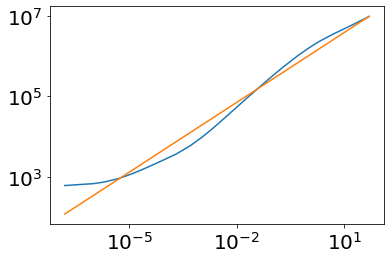

In [307]:
start = 0
plt.plot(noise_in_ratios[start:], final_norms[start:])

plt.plot(noise_in_ratios[start:], noise_in_ratios[start:]**reg.coef_[0][0] * np.exp(reg.intercept_[0]) )

plt.xscale("log")
plt.yscale("log")


The total prob mass does not seem to scale linearly with the noise term in the estimator ratio. Rather, it is some form of square - root dependence. Nevertheless, the total prob mass is monotonically increasing as expected. This already explains that points move closer together.